## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance

In [4]:
data = pd.read_csv("https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")

In [5]:
data

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease
...,...,...,...,...,...,...,...,...,...
199,Bridgett Franecki,55,0,1,128,205,2,130,No Disease
200,Mr. Foster Zieme,51,1,3,94,227,1,154,Disease
201,Lashanda Hagenes,42,1,2,120,295,1,162,Disease
202,Levern Trantow III,35,0,1,138,183,1,182,Disease


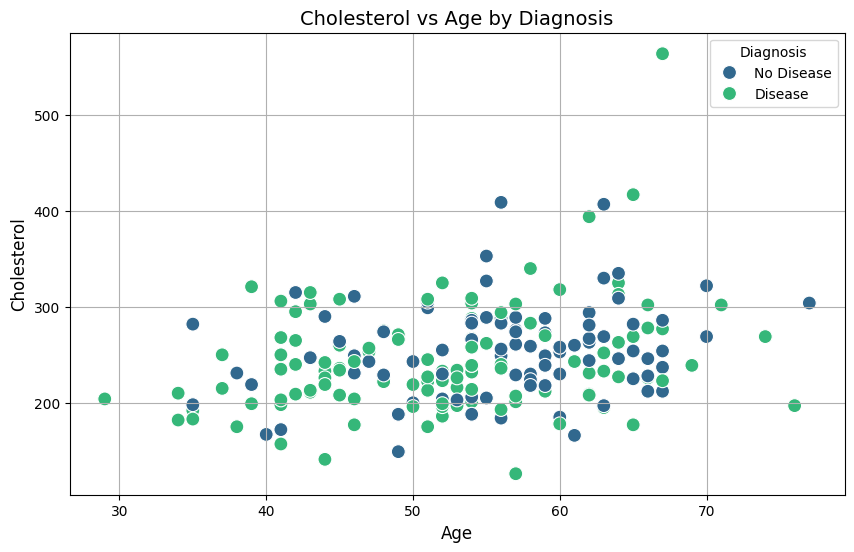

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='age', y='chol', hue='diagnosis', s=100, palette='viridis')
plt.title('Cholesterol vs Age by Diagnosis', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Cholesterol', fontsize=12)
plt.legend(title='Diagnosis')
plt.grid(True)
plt.show()

In [10]:
# Prepare the data for LDA
X = data[['age', 'chol']]
y = data['diagnosis'].map({'No Disease': 0, 'Disease': 1})  # Encode diagnosis as 0 (No Disease) and 1 (Disease)

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [11]:
from sklearn.linear_model import LogisticRegression

# Fit the Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X, y)

# Coefficients of the Logistic Regression model
log_coefficients = log_reg.coef_[0]
log_intercept = log_reg.intercept_[0]

# For a 55-year-old, calculate the cholesterol level for a 50% probability threshold (default decision boundary)
age = 55
# Decision boundary: log_intercept + age_coef * age + chol_coef * chol = 0
chol_needed_50 = (-log_intercept - log_coefficients[0] * age) / log_coefficients[1]

# For a 55-year-old, calculate the cholesterol level for a 90% probability of heart disease
# Logistic function: P = 1 / (1 + exp(-(log_intercept + age_coef * age + chol_coef * chol)))
# Solve for chol when P = 0.9
prob = 0.9
chol_needed_90 = (np.log(prob / (1 - prob)) - log_intercept - log_coefficients[0] * age) / log_coefficients[1]

chol_needed_50, chol_needed_90


(367.874889798596, -851.9660996781531)

In [12]:
log_reg.predict_proba(pd.DataFrame({'age': [55], 'chol': [367.87]}))

array([[0.4999978, 0.5000022]])

In [18]:
log_reg.predict_proba(pd.DataFrame({'age': [55], 'chol': [-851.97]}))

array([[0.09999937, 0.90000063]])

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np

# Prepare the data for LDA
X = data[['age', 'chol']]
y = data['diagnosis'].map({'No Disease': 0, 'Disease': 1})  # Encode diagnosis as 0 (No Disease) and 1 (Disease)

# Fit the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

# Coefficients of the LDA model
coefficients = lda.coef_[0]
intercept = lda.intercept_[0]

# For a 55-year-old, solve for the cholesterol level (chol) where the prediction threshold is 0.5
age = 55
# Decision boundary: intercept + age_coef * age + chol_coef * chol = 0
chol_needed = (-intercept - coefficients[0] * age) / coefficients[1]

chol_needed


368.23535752993797

In [9]:
new_data = pd.DataFrame({'age': [55], 'chol': [368.23]})
lda_pred = lda.predict(new_data)
lda_pred

array([1])

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [19]:
# Fit the Support Vector Classifier model
svc = SVC(kernel='linear', probability=True)
svc.fit(X, y)

# Coefficients of the linear SVC model
svc_coefficients = svc.coef_[0]
svc_intercept = svc.intercept_[0]

# For a 55-year-old, calculate the cholesterol level for the decision boundary
# Decision boundary: svc_intercept + age_coef * age + chol_coef * chol = 0
chol_needed_svc = (-svc_intercept - svc_coefficients[0] * age) / svc_coefficients[1]

chol_needed_svc

312.69947083425

In [34]:
new_data = pd.DataFrame({'age': [55], 'chol': [400.699]})
svc_pred = svc.predict(new_data)
svc_pred_proba = svc.predict_proba(new_data)
svc_pred_proba, svc_pred

(array([[0.49136896, 0.50863104]]), array([0]))

Tuned SVC

In [55]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear'],  # Kernel types
    'gamma': ['scale', 'auto'],  # Kernel coefficient for rbf
}

# Initialize the Support Vector Classifier
svc = SVC(probability=True)

In [56]:
# Perform GridSearchCV with reduced CV splits
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=2, scoring='accuracy')
grid_search.fit(X, y)

# Best parameters and model
best_params = grid_search.best_params_
best_svc = grid_search.best_estimator_

# Recalculate the cholesterol level for a 55-year-old with the tuned model
svc_coefficients = best_svc.coef_[0]
svc_intercept = best_svc.intercept_[0]
chol_needed_svc_tuned = (-svc_intercept - svc_coefficients[0] * age) / svc_coefficients[1]

best_params, chol_needed_svc_tuned


({'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}, 312.7019396029427)

In [57]:
new_data = pd.DataFrame({'age': [55], 'chol': [400.699]})
svc_pred = best_svc.predict(new_data)
svc_pred_proba = best_svc.predict_proba(new_data)
svc_pred_proba, svc_pred

(array([[0.45466816, 0.54533184]]), array([0]))

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

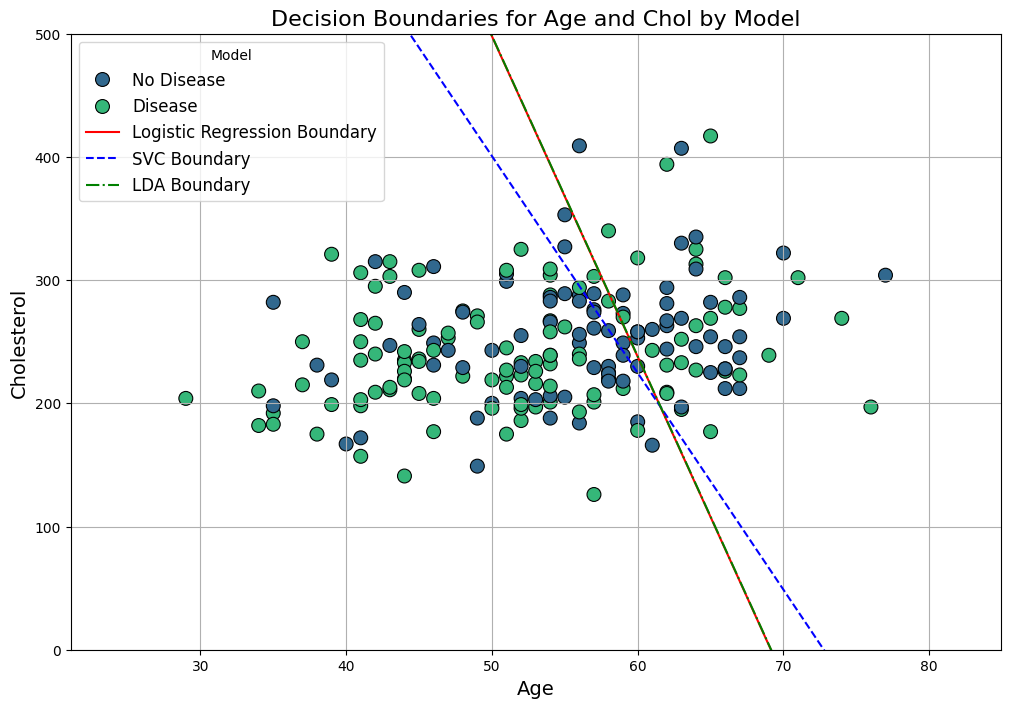

In [49]:
# Fit Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X, y)
log_coefficients = log_reg.coef_[0]
log_intercept = log_reg.intercept_[0]

# Fit SVC
svc = SVC(kernel='linear', probability=True)
svc.fit(X, y)
svc_coefficients = svc.coef_[0]
svc_intercept = svc.intercept_[0]

# Fit LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
lda_coefficients = lda.coef_[0]
lda_intercept = lda.intercept_[0]

# Generate mesh grid for plotting decision boundaries
x_min, x_max = X['age'].min() - 5, X['age'].max() + 5
y_min, y_max = X['chol'].min() + 500, X['chol'].max() - 500
xx = np.linspace(x_min, x_max, 100)
# yy = np.linspace(y_min, y_max, 100)
# xx, yy = np.meshgrid(xx, yy)

# Logistic Regression decision boundary
log_boundary = (-log_intercept - log_coefficients[0] * xx) / log_coefficients[1]

# SVC decision boundary
svc_boundary = (-svc_intercept - svc_coefficients[0] * xx) / svc_coefficients[1]

# LDA decision boundary
lda_boundary = (-lda_intercept - lda_coefficients[0] * xx) / lda_coefficients[1]

# Plot the data points
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='age', y='chol', hue='diagnosis', s=100, palette='viridis', edgecolor='black')

# Plot decision boundaries
plt.plot(xx, log_boundary, 'r-', label='Logistic Regression Boundary')
plt.plot(xx, svc_boundary, 'b--', label='SVC Boundary')
plt.plot(xx, lda_boundary, 'g-.', label='LDA Boundary')

plt.ylim(0, 500)

# Customize plot
plt.title('Decision Boundaries for Age and Chol by Model', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Cholesterol', fontsize=14)
plt.legend(title='Model', fontsize=12)
plt.grid(True)
plt.show()